**Import Tensorflow as Neural Network package**

In [1]:
import random
import pandas as pd 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf
random.seed(11)
np.random.seed(11)

In [2]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [3]:
Data = pd.read_csv('../../../4 - Data/04_WorkingDatasets/01 NormalComb/NormalCombined.csv') #All Features + comination Features without Lagged Target
Target = pd.read_csv('../../../4 - Data/04_WorkingDatasets/02 NormalCombLagged/TargetOutliersTreated.csv')

In [4]:
Target.head()

#Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,Datum,Rebgassechange,Clarahuuschange,Citychange,Storchenchange,Post Baselchange,Aeschenchange,Bahnhof Südchange,Bad. Bahnhofchange,Europechange,...,Basel Wind Speed [10 m]_x_Basel Wind Speed [10 m],Basel Wind Speed [10 m]_x_Basel Wind Direction [10 m],Basel Wind Speed [10 m]_x_Gasverbrauch,Basel Wind Speed [10 m]_x_Hour,Basel Wind Direction [10 m]_x_Basel Wind Direction [10 m],Basel Wind Direction [10 m]_x_Hour,406v_sumLW_x_408n_sumLief,660n_sumPW_x_Gasverbrauch,Gasverbrauch_x_Gasverbrauch,Gasverbrauch_x_Hour
0,2022-01-01 00:00:00+00:00,-0.489535,-1.161860,-0.163429,-1.109755,0.000016,-0.257882,-0.245185,-0.158018,-0.151099,...,-0.235434,-0.283734,-0.377593,-0.046808,-0.890521,-0.020069,-0.122035,-0.459651,-0.612347,0.040175
1,2022-01-01 01:00:00+00:00,-0.489535,-0.193676,-0.043581,-0.525585,-0.191192,0.000016,0.000115,-0.000246,-0.000068,...,-0.075257,-0.241799,-0.515062,-0.115922,-0.900547,-0.016733,0.086553,-0.576248,-0.585116,0.067887
2,2022-01-01 02:00:00+00:00,-0.279608,-0.000039,-0.010895,-0.058248,0.000016,0.000016,-0.122535,-0.000246,-0.000068,...,-0.122800,-0.053188,-0.517671,-0.175949,-0.884203,-0.040232,-0.007376,-0.590613,-0.571382,0.099923
3,2022-01-01 03:00:00+00:00,-0.209632,-0.000039,-0.010895,-0.350333,0.000016,0.000016,0.000115,-0.000246,-0.000068,...,-0.142698,-0.186471,-0.720133,-0.234521,-0.902521,-0.021412,0.156083,-0.692110,-0.417436,0.183681
4,2022-01-01 04:00:00+00:00,-0.139656,-0.000039,0.021790,0.117003,0.000016,0.000016,0.245415,-0.000246,0.150964,...,-0.239306,-0.076720,-0.998149,-0.253919,-0.882844,-0.061861,0.258004,-0.788389,0.146464,0.384286


In [5]:
#Lag Feature einbauen, da die Feinstaubkonzentration häufig von den Werten der letzten Tage abhängt 
#lag_hours = 24

# Erstelle für jede Stunde in der Vergangenheit eine Lag-Feature-Spalte
#for lag in range(1, lag_hours + 1):  
#    Data[f'Feature_lag_{lag}'] = Target['PM10_Combined_Trend_Residual'].shift(lag)

# Entfernen von Zeilen mit NaN-Werten, die durch das Verschieben der Daten entstehen
#Data.dropna(inplace=True)
# Stelle sicher, dass du NaN-Werte aus beiden X und y entfernst

# Stelle sicher, dass Target denselben Index hat wie Data
#Target = Target.loc[Data.index]

Data = Data[Data['Datum'] >= '2022-01-02 01:00:00+00:00']
Data.drop(columns = ['Datum'], inplace = True)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data = scaler.fit_transform(Data)

In [7]:
tf.random.set_seed(11)


# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.1)    # 10% Validierung
test_size = n - train_size - val_size  # 20% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [10]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])


Epoch 1/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 40.9824 - mae: 4.2833 - mse: 35.8846 - val_loss: 44.0357 - val_mae: 3.8122 - val_mse: 39.9046
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 22.5730 - mae: 3.2034 - mse: 18.7342 - val_loss: 44.2192 - val_mae: 3.8826 - val_mse: 41.0909
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.6262 - mae: 3.1122 - mse: 17.6965 - val_loss: 43.7161 - val_mae: 3.9363 - val_mse: 41.2437
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18.9647 - mae: 3.0098 - mse: 16.6217 - val_loss: 41.5298 - val_mae: 3.8237 - val_mse: 39.4484
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18.4096 - mae: 2.9889 - mse: 16.4014 - val_loss: 43.0267 - val_mae: 3.9698 - val_mse: 41.1706
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 17.7519 - mae: 2.9564 - mse: 15.9478 - val_loss: 42.2162 - val_mae: 3.9066 - val_mse: 40.5164
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - l

In [12]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(4911, 180)
(4911,)


In [13]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.3839 - mae: 3.8576 - mse: 32.7309  
Test loss, Test MAE: [18.904245376586914, 3.13784122467041, 17.251235961914062]


In [ ]:
tf.random.set_seed(11)


model2 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 72 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model2.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 43.9511 - mae: 4.4820 - mse: 38.8194 - val_loss: 45.9662 - val_mae: 3.9326 - val_mse: 41.7348
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 25.3415 - mae: 3.4466 - mse: 21.3692 - val_loss: 44.1512 - val_mae: 3.8709 - val_mse: 40.8737
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 23.0664 - mae: 3.3149 - mse: 19.9645 - val_loss: 43.2890 - val_mae: 3.9221 - val_mse: 40.6300
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21.3762 - mae: 3.2181 - mse: 18.8343 - val_loss: 41.6491 - val_mae: 3.8326 - val_mse: 39.3826
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.5664 - mae: 3.1896 - mse: 18.3799 - val_loss: 42.8435 - val_mae: 3.9212 - val_mse: 40.8684
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.4481 - mae: 3.1907 - mse: 18.5127 - val_loss: 40.3409 - val_mae: 3.8143 - val_mse: 38.5107
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 19.2

KeyboardInterrupt: 

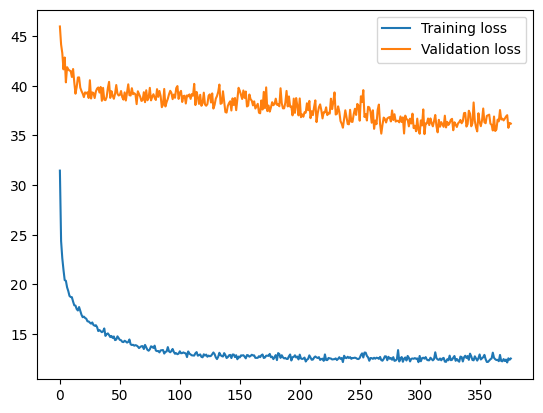

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
tf.random.set_seed(11)


model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.38, patience=10, min_lr=1e-6) # Vorschläge aus dem Internet testen



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model3.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 37.4970 - mae: 4.0414 - mse: 31.2857 - val_loss: 44.8612 - val_mae: 3.8661 - val_mse: 40.3511
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 22.4038 - mae: 3.1706 - mse: 18.3555 - val_loss: 42.8175 - val_mae: 3.8372 - val_mse: 39.8119
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.0054 - mae: 3.0700 - mse: 17.2313 - val_loss: 42.0393 - val_mae: 3.8187 - val_mse: 39.7446
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.4388 - mae: 2.9913 - mse: 16.2840 - val_loss: 41.1233 - val_mae: 3.8023 - val_mse: 39.1957
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.9778 - mae: 2.9599 - mse: 16.1303 - val_loss: 40.3810 - val_mae: 3.7802 - val_mse: 38.6532
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.5416 - mae: 2.9405 - mse: 15.8718 - val_loss: 40.0570 - val_mae: 3.7747 - val_mse: 38.4487
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.7299

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7661 - mae: 1.4841 - mse: 4.2201  
Test loss, Test MAE: [5.42454195022583, 1.6282896995544434, 4.878493785858154]

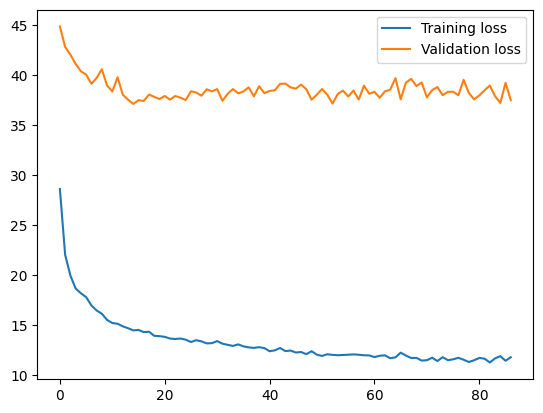

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


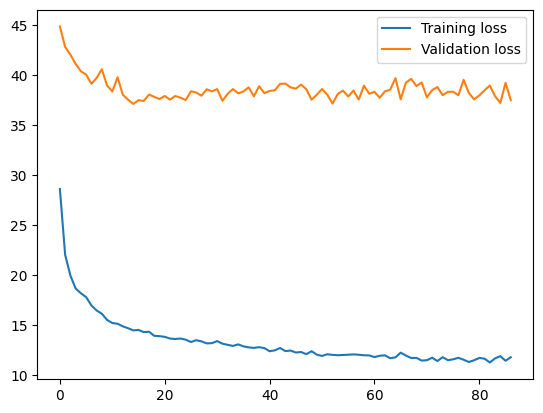

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
tf.random.set_seed(11)

model4 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)


history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model4.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 46.7340 - mae: 4.5200 - mse: 41.5806 - val_loss: 45.2780 - val_mae: 3.9684 - val_mse: 41.5816
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - loss: 19.4275 - mae: 2.9720 - mse: 16.0574 - val_loss: 42.9443 - val_mae: 3.8728 - val_mse: 40.3165
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - loss: 17.7251 - mae: 2.8854 - mse: 15.2578 - val_loss: 42.4474 - val_mae: 3.8647 - val_mse: 40.3262
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - loss: 16.5272 - mae: 2.8100 - mse: 14.5014 - val_loss: 42.6669 - val_mae: 3.9105 - val_mse: 40.8465
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 16.0961 - mae: 2.7875 - mse: 14.3305 - val_loss: 42.0467 - val_mae: 3.8741 - val_mse: 40.3831
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - loss: 15.9034 - mae: 2.7844 - mse: 14.2818 - val_loss: 41.0387 - val_mae: 3.8413 - val_mse: 39.4761
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - los